In [242]:
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


import pandas as pd
from collections import defaultdict
from datetime import datetime

from ExtractData import parse_orders

In [243]:
file_path = 'CsvReaderOutput.txt'
orders = parse_orders(file_path)

In [245]:
def get_day_of_week(order_timestamp):
    #0=Monday, 6=Sunday
    return datetime.strptime(order_timestamp, '%Y-%m-%d %H:%M:%S').weekday()

In [246]:
def find_top_n_items(orders, n=50):
    # Flatten the list of items from all orders
    all_items = [item for order in orders for item in order['items']]
    
    # Count occurrences of each item using Counter
    item_counts = Counter(all_items)
    
    most_common_items = [item for item, _ in item_counts.most_common(n)]
    
    return most_common_items

In [247]:
def aggregate_sales_by_date(orders, top_items):
    sales_data = defaultdict(lambda: defaultdict(int))
    
    for order in orders:
        date = order['order_timestamp'].split(" ")[0]  # Extract just the date
        for item in order['items']:
            if item in top_items:
                sales_data[date][item] += 1

    data = []
    for date, items in sales_data.items():
        day_of_week = datetime.strptime(date, '%Y-%m-%d').weekday()
        is_weekend = 1 if day_of_week >= 5 else 0
        for item, count in items.items():
            data.append({
                'date': date,
                'day_of_week': day_of_week,
                'item_name': item,
                'sales_count': count,
                'is_weekend': is_weekend
            })
    
    df = pd.DataFrame(data)

    def get_surrounding_sales(row, sales_data):
        current_date = datetime.strptime(row['date'], '%Y-%m-%d')
        item = row['item_name']
        total_sales = row['sales_count']
        
        surrounding_sales = 0
        
        for offset in range(-2, 3):  # Get sales from two days before and after
            if offset == 0:
                continue
            surrounding_date = (current_date + pd.Timedelta(days=offset)).strftime('%Y-%m-%d')
            if surrounding_date in sales_data and item in sales_data[surrounding_date]:
                surrounding_sales += sales_data[surrounding_date][item]
        
        return surrounding_sales

    df['surrounding_sales'] = df.apply(lambda row: get_surrounding_sales(row, sales_data), axis=1)

    return df


most_ordered_items = find_top_n_items(orders, n=50)
sales_df = aggregate_sales_by_date(orders, top_items=most_ordered_items)

print(sales_df.head())

         date  day_of_week                       item_name  sales_count  \
0  2022-12-01            3  BUNDY LEMON LIM BITTER CAN 6PK            2   
1  2022-12-01            3         BUNDY COLA 4.6% CAN 6PK           10   
2  2022-12-01            3        JDANIEL DBL JACK CAN 4PK            4   
3  2022-12-01            3               XXXX GOLD CAN 6PK           52   
4  2022-12-01            3                     VB 750ML EA            6   

   is_weekend  surrounding_sales  
0           0                  3  
1           0                 28  
2           0                  3  
3           0                 48  
4           0                  4  


In [248]:
most_ordered_items = find_top_n_items(orders, n=50)
print(most_ordered_items)

['XXXX GOLD CAN 6PK', 'ICE 5kg BAG', 'GREAT NTHN MID 30 BLOCK', 'BUNDY COLA 4.6% CAN 6PK', 'BILLSONS VODKA CAN 4PK', 'GREAT NTHN ORIGINAL STUB CTN', 'XXXX GOLD CAN CTN 30PK', 'CRUISER BTL 4PK', 'COCA COLA 1.25L', 'CORONA MEX STUB CTN', 'GREAT NTHN ORIGINAL 700ML EA', 'XXXX DRY CAN 6PK', 'GREAT NTHN ORIGINAL CAN 30CTN', 'BROOKVALE GINGER 330ML CAN 6PK', 'SCHWEPPES 2 FOR 5', 'GREAT NTHN ORIGINAL STUB 6PK', 'GREAT NTHN MID STUB CTN', 'GREAT NTHN MID 700ML', 'BUNDY GINGER 4% CAN 6PK', 'FIREBALL XMAS ORNAMENT SGL', 'LUCKY DIP MINIATURES', 'BUNDY UP RUM 1000ML', 'SUNTORY 196 LEMON 6% CAN 10PK', 'COOPERS PALE 750ML TALLIE EA', 'BUNDY OP/COLA 6.0% CAN EA', 'VB 750ML EA', 'BUNDY RED/COLA CAN 6PK', 'SCHWEPPES SODA 1.1L', 'JDANIEL DBL JACK CAN 4PK', 'ARIANE VODKA 700ML', '10 TOES IPA CAN SGL', 'CARL DRY BTL CTN', 'GREAT NTHN MID CAN 6PK', 'GREAT NTHN MID STUB 6PK', 'BUNDY LEMON LIM BITTER CAN 6PK', 'WTURKEY 101 CAN 4PK', 'PARTY SHOTS SGL', 'WSTOCK COLA 12% CAN 4PK', 'CHEMIN DES SABLES ROSE', 'JDA

In [249]:
sales_df = aggregate_sales_by_date(orders, top_items=most_ordered_items)

In [250]:
print(sales_df)

            date  day_of_week                       item_name  sales_count  \
0     2022-12-01            3  BUNDY LEMON LIM BITTER CAN 6PK            2   
1     2022-12-01            3         BUNDY COLA 4.6% CAN 6PK           10   
2     2022-12-01            3        JDANIEL DBL JACK CAN 4PK            4   
3     2022-12-01            3               XXXX GOLD CAN 6PK           52   
4     2022-12-01            3                     VB 750ML EA            6   
5     2022-12-01            3         GREAT NTHN MID 30 BLOCK           16   
6     2022-12-01            3     EUMUNDI GINGER BEER CAN 4PK            4   
7     2022-12-01            3                XXXX DRY CAN 6PK            4   
8     2022-12-01            3          XXXX GOLD CAN CTN 30PK           12   
9     2022-12-01            3                     ICE 5kg BAG            8   
10    2022-12-01            3       BUNDY OP/COLA 6.0% CAN EA           10   
11    2022-12-01            3             10 TOES IPA CAN SGL   

In [251]:
#X = sales_df[['day_of_week', 'item_name', 'is_weekend', 'surrounding_sales']]
#y = sales_df['sales_count']

In [252]:
sales_df_sorted = sales_df.sort_values(by='sales_count', ascending=False)

# Print sorted DataFrame
print(sales_df_sorted)
print(sales_df_sorted.shape)

            date  day_of_week                       item_name  sales_count  \
232   2022-12-24            5      FIREBALL XMAS ORNAMENT SGL           86   
236   2022-12-24            5                     ICE 5kg BAG           70   
738   2022-12-06            1               XXXX GOLD CAN 6PK           70   
973   2022-12-05            0               XXXX GOLD CAN 6PK           68   
703   2022-12-16            4               XXXX GOLD CAN 6PK           62   
396   2022-12-09            4               XXXX GOLD CAN 6PK           52   
3     2022-12-01            3               XXXX GOLD CAN 6PK           52   
354   2022-12-08            3               XXXX GOLD CAN 6PK           50   
663   2022-12-07            2               XXXX GOLD CAN 6PK           46   
1129  2022-12-13            1               XXXX GOLD CAN 6PK           45   
951   2022-12-15            3               XXXX GOLD CAN 6PK           42   
514   2022-12-31            5                     ICE 5kg BAG   

In [253]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [254]:
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [255]:
#if isinstance(x_train, pd.Series):
#    x_train = x_train.to_frame()
#if isinstance(x_test, pd.Series):
#    x_test = x_test.to_frame()

In [256]:
#print("Columns in x_train:", x_train.columns)

In [257]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['day_of_week', 'item_name']),
        ('num', 'passthrough', ['is_weekend', 'surrounding_sales'])
    ],
    remainder='passthrough'
)

In [258]:
kf = KFold(n_splits=5, shuffle=True, random_state=50)
fold = 1
fold_mse = []

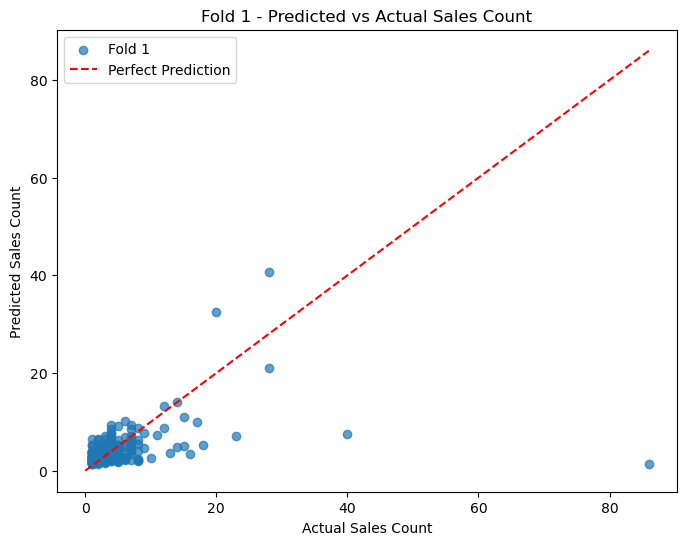

Fold 1 - MSE: 45.2045694221063


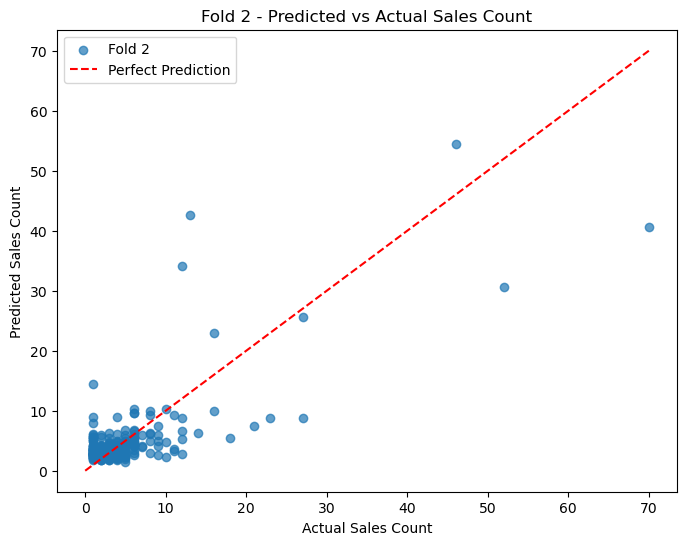

Fold 2 - MSE: 22.88056889316627


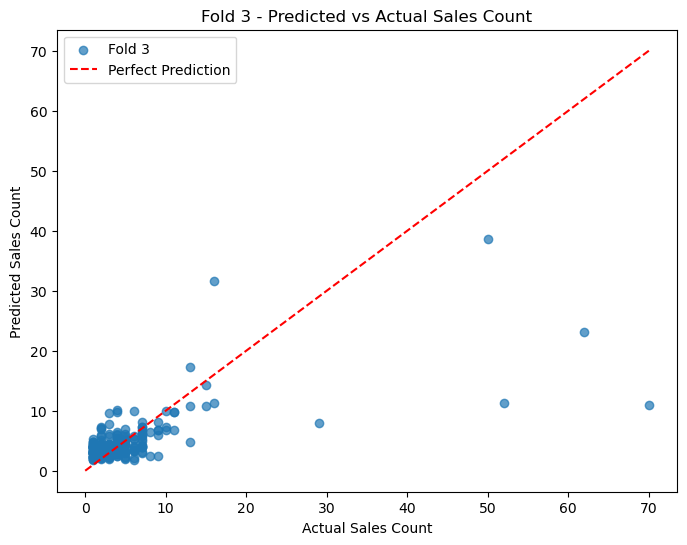

Fold 3 - MSE: 37.20198595814101


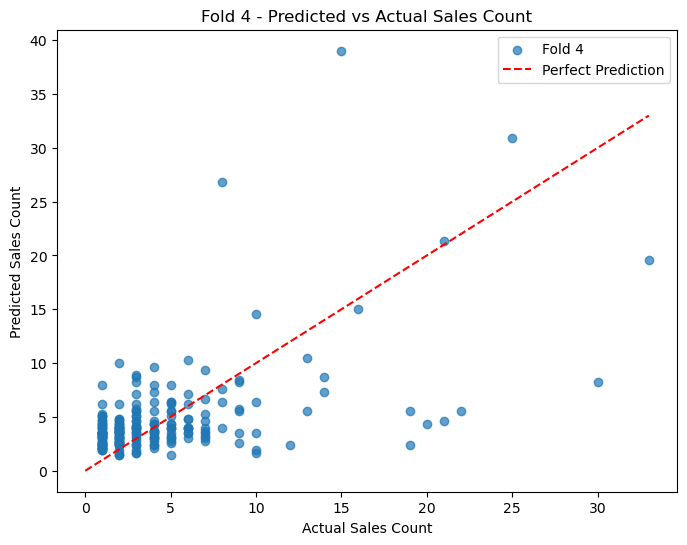

Fold 4 - MSE: 19.33394612650127


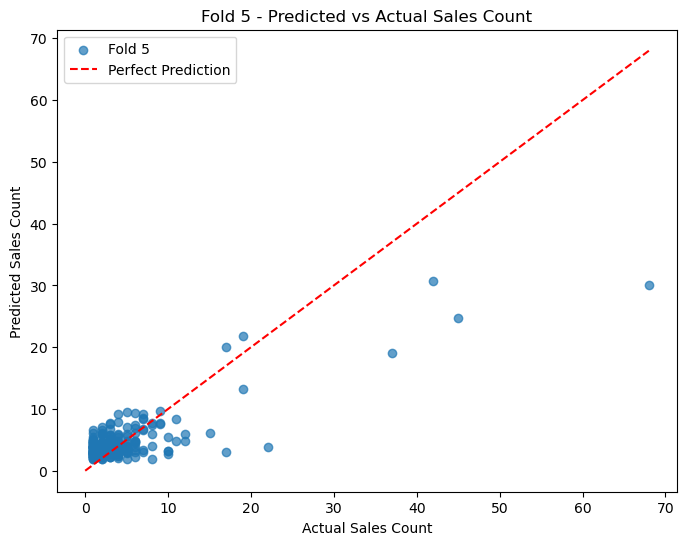

Fold 5 - MSE: 18.454552601674735


In [259]:
for train_index, test_index in kf.split(sales_df):
    train_data, test_data = sales_df.iloc[train_index], sales_df.iloc[test_index]
    x_train, y_train = train_data[['day_of_week', 'item_name', 'is_weekend', 'surrounding_sales']], train_data['sales_count']
    x_test, y_test = test_data[['day_of_week', 'item_name', 'is_weekend', 'surrounding_sales']], test_data['sales_count']

    x_train_encoded = preprocessor.fit_transform(x_train)
    x_test_encoded = preprocessor.transform(x_test)
    
    lasso = Lasso()
    lasso.fit(x_train_encoded, y_train)

    y_pred = lasso.predict(x_test_encoded)
    mse = mean_squared_error(y_test, y_pred)
    fold_mse.append(mse)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, label=f"Fold {fold}")
    plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
    plt.title(f"Fold {fold} - Predicted vs Actual Sales Count")
    plt.xlabel("Actual Sales Count")
    plt.ylabel("Predicted Sales Count")
    plt.legend()
    plt.show()
    
    print(f"Fold {fold} - MSE: {mse}")
    fold += 1

In [260]:
#x_train_encoded = preprocessor.fit_transform(x_train)
#x_test_encoded = preprocessor.transform(x_test)
#encoded_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(input_features=['day_of_week', 'item_name'])
#encoded_feature_names = list(encoded_feature_names) + ['is_weekend', 'surrounding_sales']
#print("Encoded feature names:", encoded_feature_names)

In [261]:
#lasso = Lasso()
#lasso.fit(x_train_encoded, y_train)
#lasso_coefs = lasso.coef_
#mask = np.abs(lasso_coefs) > 0.001
#features = np.where(mask)[0]
#num_feat = len(features)
#print("Number of important features:", num_feat)
#print("Non-zero coefficients indices:", features)

In [262]:
train_score = lasso.score(x_train_encoded, y_train)
test_score = lasso.score(x_test_encoded, y_test)

In [263]:
print(f"Training R^2 Score: {train_score}")
print(f"Test R^2 Score: {test_score}")

Training R^2 Score: 0.35852279357650163
Test R^2 Score: 0.6072229485539908


In [264]:
y_pred = lasso.predict(x_test_encoded)

In [265]:
print("Predictions vs Actual Sales:")
for actual, pred in zip(y_test[:], y_pred[:]):
    print(f"Actual: {actual}, Predicted: {pred}")

Predictions vs Actual Sales:
Actual: 2, Predicted: 2.4551828129042916
Actual: 4, Predicted: 3.0429694001133614
Actual: 10, Predicted: 2.651111675307315
Actual: 6, Predicted: 3.434827124919408
Actual: 2, Predicted: 2.8470405377103383
Actual: 6, Predicted: 3.0429694001133614
Actual: 7, Predicted: 9.116764134607083
Actual: 2, Predicted: 3.6307559873224315
Actual: 1, Predicted: 5.198186886546617
Actual: 2, Predicted: 2.4551828129042916
Actual: 1, Predicted: 2.063325088098245
Actual: 6, Predicted: 4.610400299337547
Actual: 1, Predicted: 4.806329161740571
Actual: 2, Predicted: 5.9819023361587105
Actual: 1, Predicted: 5.394115748949641
Actual: 1, Predicted: 4.806329161740571
Actual: 1, Predicted: 3.8266848497254546
Actual: 1, Predicted: 3.8266848497254546
Actual: 19, Predicted: 21.852140190803595
Actual: 4, Predicted: 9.116764134607083
Actual: 6, Predicted: 4.806329161740571
Actual: 3, Predicted: 4.806329161740571
Actual: 3, Predicted: 3.0429694001133614
Actual: 1, Predicted: 3.43482712491940

In [266]:
import pandas as pd
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns

x_test['predicted_sales'] = y_pred
x_test_sorted = x_test.sort_values(by='predicted_sales', ascending=False)

item_name_to_search = input("Enter the item name you want to search for: ")

filtered_data = x_test_sorted[x_test_sorted['item_name'] == item_name_to_search]

if not filtered_data.empty:
    print(f"\nPredicted Sales for Item: {item_name_to_search}")
    print(filtered_data)
else:
    print(f"\nNo data found for item: {item_name_to_search}")

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_65901/2221674864.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['predicted_sales'] = y_pred


Enter the item name you want to search for:  a



No data found for item: a


In [267]:
print(sales_df[sales_df['item_name'] == 'BUNDY COLA 4.6% CAN 6PK'])
column_names = preprocessor.transformers_[0][1].get_feature_names_out(input_features=['day_of_week', 'item_name'])
print(column_names)


            date  day_of_week                item_name  sales_count  \
1     2022-12-01            3  BUNDY COLA 4.6% CAN 6PK           10   
40    2022-12-11            6  BUNDY COLA 4.6% CAN 6PK            7   
81    2022-12-19            0  BUNDY COLA 4.6% CAN 6PK           12   
116   2022-12-10            5  BUNDY COLA 4.6% CAN 6PK            8   
196   2022-12-02            4  BUNDY COLA 4.6% CAN 6PK           22   
244   2022-12-24            5  BUNDY COLA 4.6% CAN 6PK           18   
281   2022-12-03            5  BUNDY COLA 4.6% CAN 6PK            6   
314   2022-12-18            6  BUNDY COLA 4.6% CAN 6PK            4   
360   2022-12-08            3  BUNDY COLA 4.6% CAN 6PK            6   
399   2022-12-09            4  BUNDY COLA 4.6% CAN 6PK           23   
441   2022-12-26            0  BUNDY COLA 4.6% CAN 6PK            2   
488   2022-12-21            2  BUNDY COLA 4.6% CAN 6PK            8   
511   2022-12-31            5  BUNDY COLA 4.6% CAN 6PK           10   
571   

In [268]:
print(sales_df[['day_of_week', 'is_weekend']].head(50))

    day_of_week  is_weekend
0             3           0
1             3           0
2             3           0
3             3           0
4             3           0
5             3           0
6             3           0
7             3           0
8             3           0
9             3           0
10            3           0
11            3           0
12            3           0
13            3           0
14            3           0
15            3           0
16            3           0
17            3           0
18            3           0
19            3           0
20            3           0
21            3           0
22            3           0
23            3           0
24            3           0
25            3           0
26            3           0
27            3           0
28            3           0
29            3           0
30            3           0
31            3           0
32            3           0
33            3           0
34            3     

In [269]:
item_name = 'XXXX GOLD CAN 6PK'
days_for_item = x_train[x_train['item_name'] == item_name]['day_of_week'].value_counts()
print(f"Day distribution for item '{item_name}' in training data:\n", days_for_item)

Day distribution for item 'XXXX GOLD CAN 6PK' in training data:
 day_of_week
5    5
4    5
2    4
3    3
6    3
1    2
0    2
Name: count, dtype: int64


In [270]:
X = sales_df[['day_of_week', 'item_name', 'is_weekend', 'surrounding_sales']]
y = sales_df['sales_count']

preprocessor.fit(X)
X_encoded = preprocessor.transform(X)

final_lasso = Lasso()
final_lasso.fit(X_encoded, y)

one_hot_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['day_of_week', 'item_name'])
encoded_feature_names = list(one_hot_features) + ['is_weekend', 'surrounding_sales']

final_lasso_coefs = final_lasso.coef_

# Print coefficients
print("Feature Coefficients After Full Training:")
for feature, coef in zip(encoded_feature_names, final_lasso_coefs):
    print(f"{feature}: {coef}")


Feature Coefficients After Full Training:
day_of_week_0: -0.0
day_of_week_1: -0.0
day_of_week_2: -0.0
day_of_week_3: -0.0
day_of_week_4: 0.0
day_of_week_5: 0.0
day_of_week_6: -0.0
item_name_10 TOES IPA CAN SGL: 0.0
item_name_ARIANE VODKA 700ML: 0.0
item_name_BILLSONS VODKA CAN 4PK: 0.0
item_name_BLACKFLAG RAGE MACHINE CAN SGL: -0.0
item_name_BROOKVALE GINGER 330ML CAN 6PK: -0.0
item_name_BROOKVALE VOD LSQ 6% CAN 4PK: -0.0
item_name_BUNDY COLA 4.6% CAN 6PK: 0.0
item_name_BUNDY GINGER 4% CAN 6PK: 0.0
item_name_BUNDY LEMON LIM BITTER CAN 6PK: -0.0
item_name_BUNDY OP/COLA 10PK: -0.0
item_name_BUNDY OP/COLA 6.0% CAN EA: -0.0
item_name_BUNDY RED/COLA CAN 6PK: -0.0
item_name_BUNDY UP RUM 1000ML: -0.0
item_name_BUNDY UP/COLA 640ML EA: -0.0
item_name_CARL DRY BTL CTN: -0.0
item_name_CHEMIN DES SABLES ROSE: -0.0
item_name_COCA COLA 1.25L: -0.0
item_name_COOPERS PALE 750ML TALLIE EA: -0.0
item_name_CORONA MEX STUB 6PK: -0.0
item_name_CORONA MEX STUB CTN: -0.0
item_name_CRUISER 600ML BTL SGL: 0.0


In [271]:
#Compare coefficients
#items_to_compare = ['item_name_5% BSHOP L.LEGEND', 'item_name_BUNDY RED/COLA CAN 6PK']
#for item in items_to_compare:
#    item_index = np.where(encoded_feature_names == item)[0][0]
#    item_coef = lasso_coefs[item_index]
#    print(f"Coefficient for '{item}': {item_coef}")


In [272]:
print("Encoded feature names:", encoded_feature_names)

Encoded feature names: ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'item_name_10 TOES IPA CAN SGL', 'item_name_ARIANE VODKA 700ML', 'item_name_BILLSONS VODKA CAN 4PK', 'item_name_BLACKFLAG RAGE MACHINE CAN SGL', 'item_name_BROOKVALE GINGER 330ML CAN 6PK', 'item_name_BROOKVALE VOD LSQ 6% CAN 4PK', 'item_name_BUNDY COLA 4.6% CAN 6PK', 'item_name_BUNDY GINGER 4% CAN 6PK', 'item_name_BUNDY LEMON LIM BITTER CAN 6PK', 'item_name_BUNDY OP/COLA 10PK', 'item_name_BUNDY OP/COLA 6.0% CAN EA', 'item_name_BUNDY RED/COLA CAN 6PK', 'item_name_BUNDY UP RUM 1000ML', 'item_name_BUNDY UP/COLA 640ML EA', 'item_name_CARL DRY BTL CTN', 'item_name_CHEMIN DES SABLES ROSE', 'item_name_COCA COLA 1.25L', 'item_name_COOPERS PALE 750ML TALLIE EA', 'item_name_CORONA MEX STUB 6PK', 'item_name_CORONA MEX STUB CTN', 'item_name_CRUISER 600ML BTL SGL', 'item_name_CRUISER BTL 4PK', 'item_name_EUMUNDI GINGER BEER CAN 4PK', 'item_name_FIREBALL XMAS

In [273]:
import pandas as pd
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns

x_test['predicted_sales'] = y_pred
x_test_sorted = x_test.sort_values(by='predicted_sales', ascending=False)

item_name_to_search = input("Enter the item name you want to search for: ")
day_of_week_to_search = int(input("Enter the day of the week (0=Monday, 6=Sunday): "))

filtered_data = x_test_sorted[(x_test_sorted['item_name'] == item_name_to_search) & 
                              (x_test_sorted['day_of_week'] == day_of_week_to_search)]

if not filtered_data.empty:
    print(f"\nPredicted Sales for Item: {item_name_to_search} on Day {day_of_week_to_search}")
    print(filtered_data[['item_name', 'day_of_week', 'predicted_sales']])
else:
    print(f"\nNo data found for item: {item_name_to_search} on day {day_of_week_to_search}")

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


/var/folders/_n/zqwvc56j1m5519qx4zmzwmtm0000gn/T/ipykernel_65901/2179203835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['predicted_sales'] = y_pred


Enter the item name you want to search for:  a
Enter the day of the week (0=Monday, 6=Sunday):  2



No data found for item: a on day 2


In [274]:
item_counts = sales_df['item_name'].value_counts()

item_name_to_search = 'XXXX GOLD CAN 6PK'

item_count = item_counts.get(item_name_to_search, 0)

total_sales = sales_df[sales_df['item_name'] == item_name_to_search]['sales_count'].sum()

print(f"The item '{item_name_to_search}' appears {item_count} times in the training data.")
print(f"The item '{item_name_to_search}' was sold {total_sales} times in total.")


The item 'XXXX GOLD CAN 6PK' appears 30 times in the training data.
The item 'XXXX GOLD CAN 6PK' was sold 891 times in total.


In [275]:
item_name_to_search = 'XXXX GOLD CAN 6PK'

train_filtered = x_train[x_train['item_name'] == item_name_to_search]
test_filtered = x_test[x_test['item_name'] == item_name_to_search]

total_quantity_sold_train = y_train[train_filtered.index].sum()
total_quantity_sold_test = y_test[test_filtered.index].sum()

print(f"The item '{item_name_to_search}' was sold {total_quantity_sold_train} times in the training data.")
print(f"The item '{item_name_to_search}' was sold {total_quantity_sold_test} times in the testing data.")


The item 'XXXX GOLD CAN 6PK' was sold 661 times in the training data.
The item 'XXXX GOLD CAN 6PK' was sold 230 times in the testing data.


In [276]:
item_name_to_search = 'XXXX GOLD CAN 6PK'

train_filtered = x_train[x_train['item_name'] == item_name_to_search]
test_filtered = x_test[x_test['item_name'] == item_name_to_search]

total_quantity_sold_train = y_train[train_filtered.index].sum()
total_quantity_sold_test = y_test[test_filtered.index].sum()

print(f"The item '{item_name_to_search}' was sold {total_quantity_sold_train} times in the training data.")
print(f"The item '{item_name_to_search}' was sold {total_quantity_sold_test} times in the testing data.")


The item 'XXXX GOLD CAN 6PK' was sold 661 times in the training data.
The item 'XXXX GOLD CAN 6PK' was sold 230 times in the testing data.


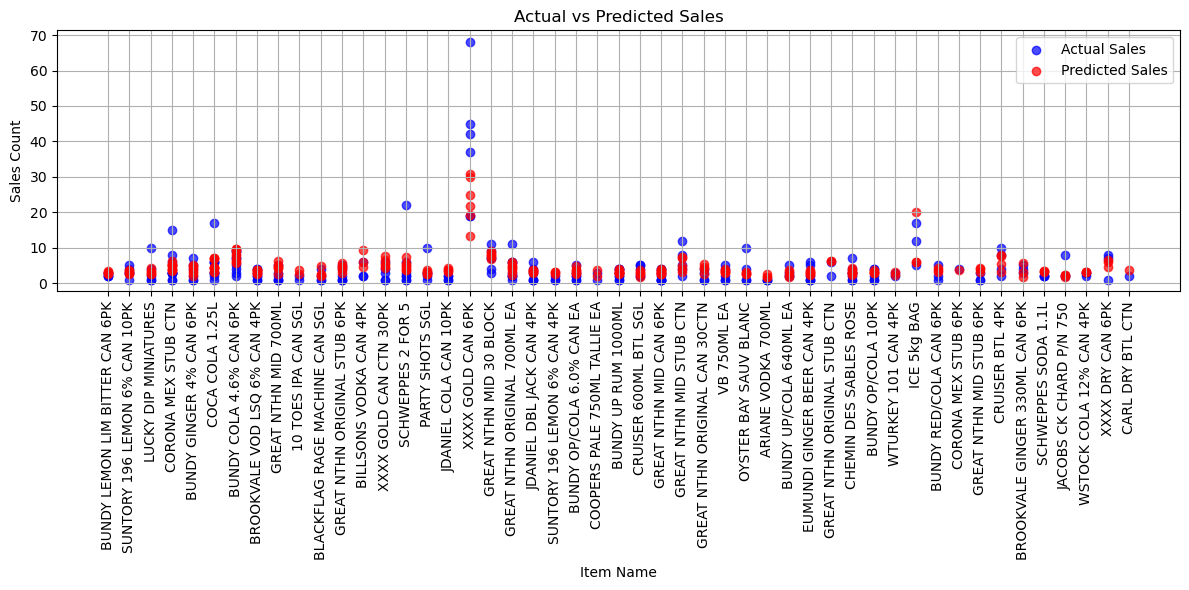

In [277]:
import matplotlib.pyplot as plt

item_names = x_test['item_name'].values

plt.figure(figsize=(12, 6))
plt.scatter(item_names, y_test, label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(item_names, y_pred, label='Predicted Sales', color='red', alpha=0.7)

plt.title('Actual vs Predicted Sales')
plt.xlabel('Item Name')
plt.ylabel('Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.show()


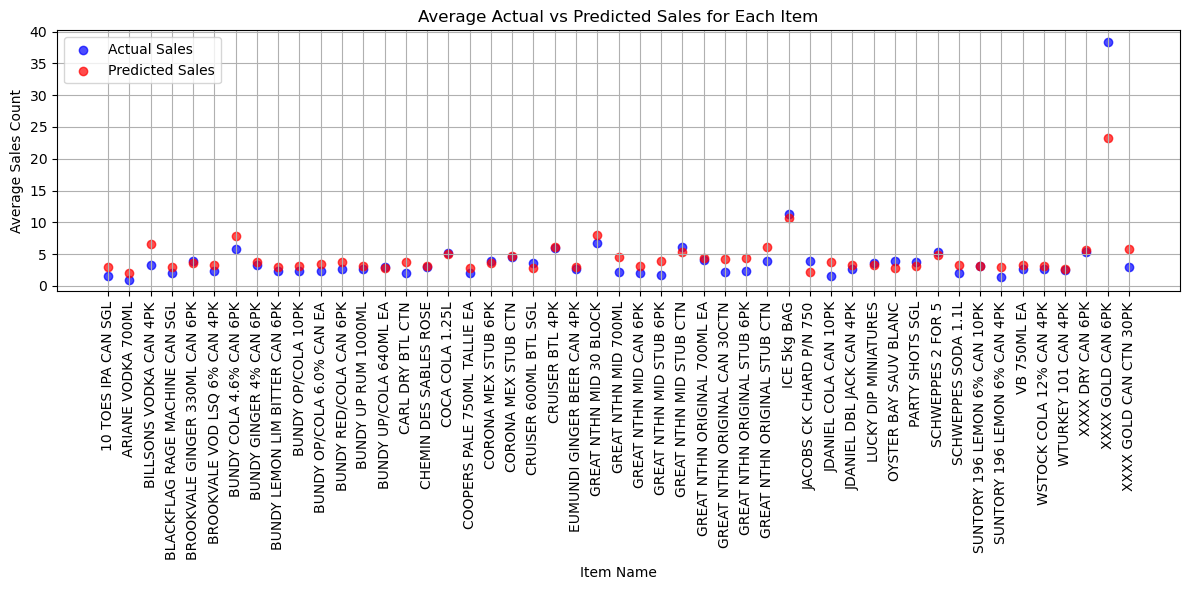

In [278]:
import pandas as pd
import matplotlib.pyplot as plt


result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred
})

grouped_df = result_df.groupby('item_name').agg(
    actual_sales=('actual_sales', 'mean'),
    predicted_sales=('predicted_sales', 'mean')
).reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(grouped_df['item_name'], grouped_df['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(grouped_df['item_name'], grouped_df['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Average Actual vs Predicted Sales for Each Item')
plt.xlabel('Item Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.show()

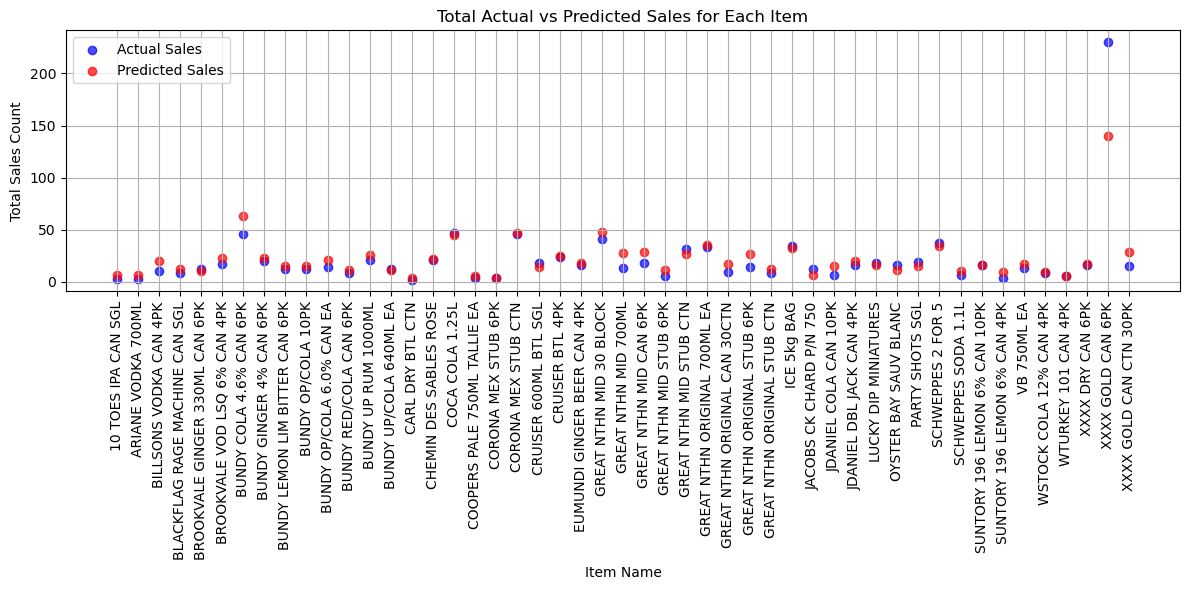

In [279]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred
})

grouped_df = result_df.groupby('item_name').agg(
    actual_sales=('actual_sales', 'sum'), 
    predicted_sales=('predicted_sales', 'sum') 
).reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(grouped_df['item_name'], grouped_df['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(grouped_df['item_name'], grouped_df['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Total Actual vs Predicted Sales for Each Item')
plt.xlabel('Item Name')
plt.ylabel('Total Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.show()

In [ ]:
#Note the plots are from here on out are just copy pasted and with the day changed. This is mainly for debugging and 
#I did not bother changing the date on the title

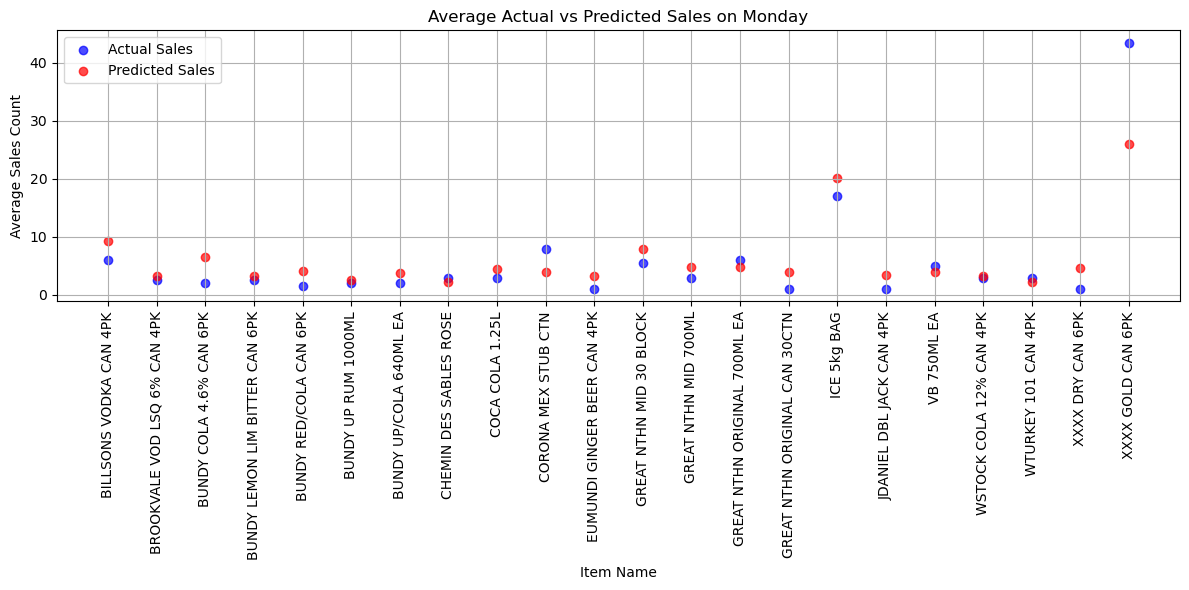

In [280]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred,
    'day_of_week': x_test['day_of_week']
})

grouped_df = result_df.groupby(['day_of_week', 'item_name']).agg(
    actual_sales=('actual_sales', 'mean'),
    predicted_sales=('predicted_sales', 'mean')
).reset_index()

monday_data = grouped_df[grouped_df['day_of_week'] == 0]

plt.figure(figsize=(12, 6))

plt.scatter(monday_data['item_name'], monday_data['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(monday_data['item_name'], monday_data['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Average Actual vs Predicted Sales on Monday')
plt.xlabel('Item Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)


plt.show()


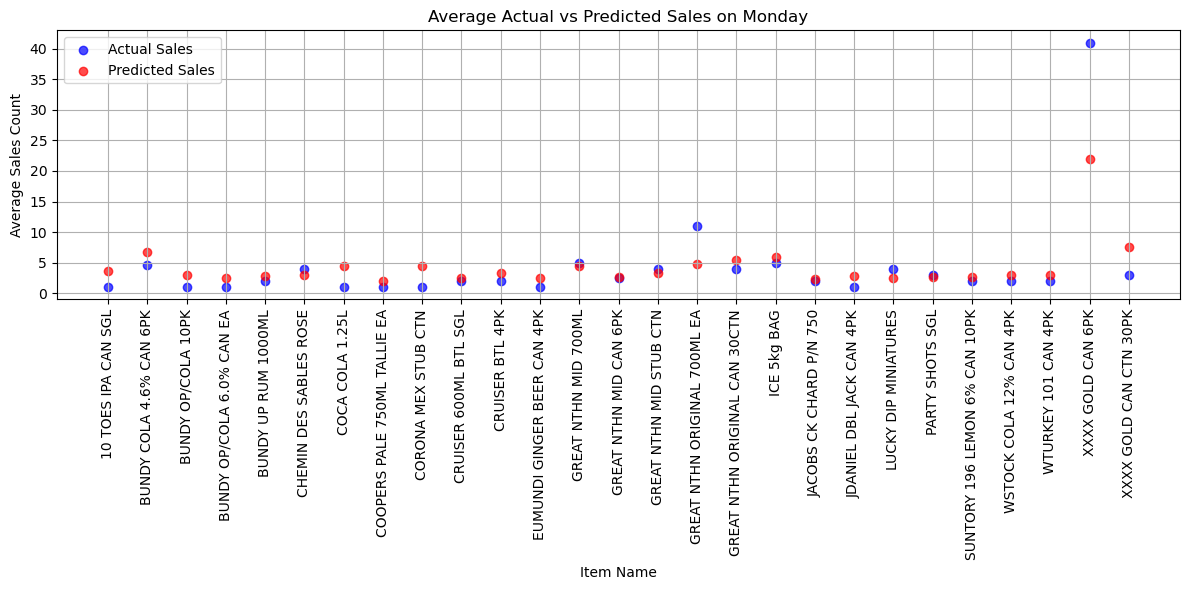

In [281]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred,
    'day_of_week': x_test['day_of_week']
})

grouped_df = result_df.groupby(['day_of_week', 'item_name']).agg(
    actual_sales=('actual_sales', 'mean'),
    predicted_sales=('predicted_sales', 'mean')
).reset_index()

monday_data = grouped_df[grouped_df['day_of_week'] == 1]

plt.figure(figsize=(12, 6))

plt.scatter(monday_data['item_name'], monday_data['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(monday_data['item_name'], monday_data['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Average Actual vs Predicted Sales on Monday')
plt.xlabel('Item Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)


plt.show()


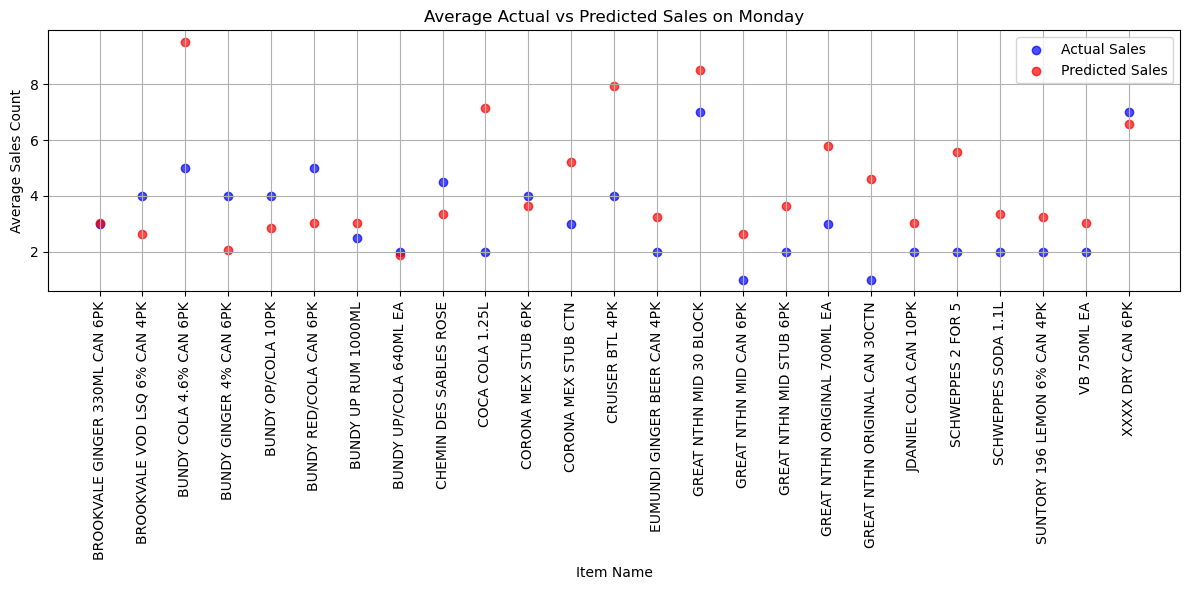

In [282]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred,
    'day_of_week': x_test['day_of_week']
})

grouped_df = result_df.groupby(['day_of_week', 'item_name']).agg(
    actual_sales=('actual_sales', 'mean'),
    predicted_sales=('predicted_sales', 'mean')
).reset_index()

monday_data = grouped_df[grouped_df['day_of_week'] == 2]

plt.figure(figsize=(12, 6))

plt.scatter(monday_data['item_name'], monday_data['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(monday_data['item_name'], monday_data['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Average Actual vs Predicted Sales on Monday')
plt.xlabel('Item Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)


plt.show()


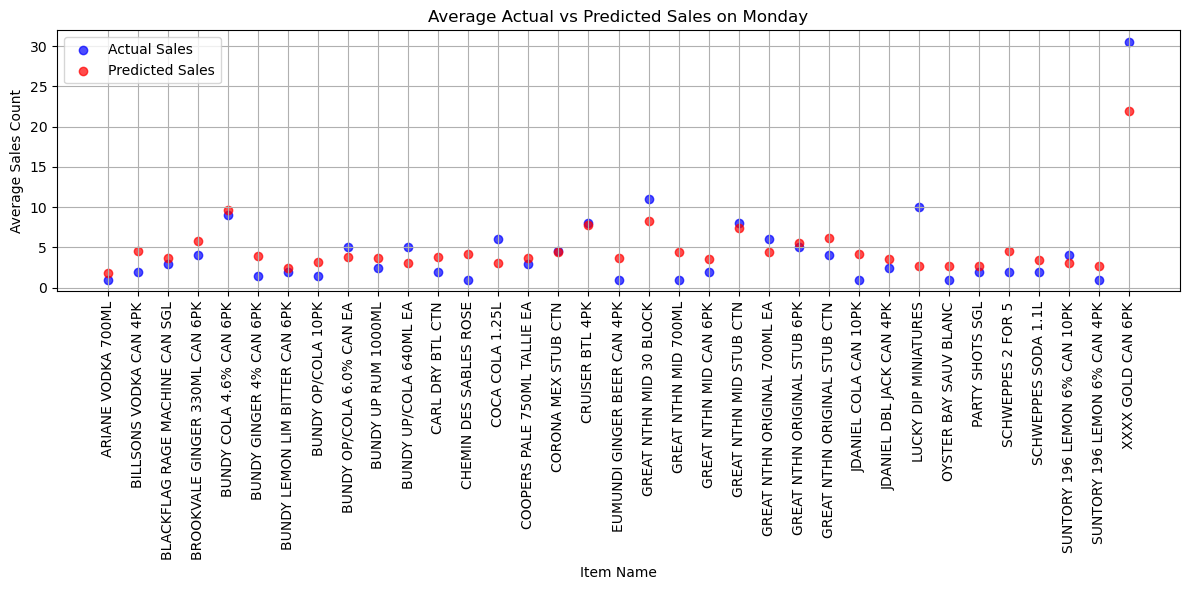

In [283]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred,
    'day_of_week': x_test['day_of_week']
})

grouped_df = result_df.groupby(['day_of_week', 'item_name']).agg(
    actual_sales=('actual_sales', 'mean'),
    predicted_sales=('predicted_sales', 'mean')
).reset_index()

monday_data = grouped_df[grouped_df['day_of_week'] == 3]

plt.figure(figsize=(12, 6))

plt.scatter(monday_data['item_name'], monday_data['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(monday_data['item_name'], monday_data['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Average Actual vs Predicted Sales on Monday')
plt.xlabel('Item Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)


plt.show()


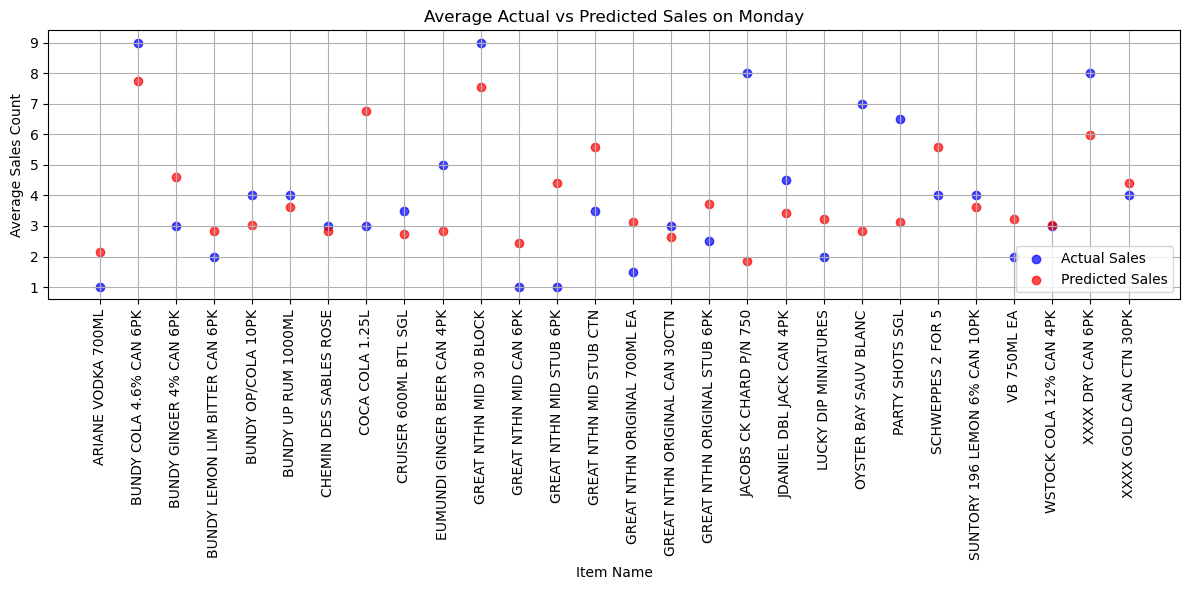

In [284]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred,
    'day_of_week': x_test['day_of_week']
})

grouped_df = result_df.groupby(['day_of_week', 'item_name']).agg(
    actual_sales=('actual_sales', 'mean'),
    predicted_sales=('predicted_sales', 'mean')
).reset_index()

monday_data = grouped_df[grouped_df['day_of_week'] == 4]

plt.figure(figsize=(12, 6))

plt.scatter(monday_data['item_name'], monday_data['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(monday_data['item_name'], monday_data['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Average Actual vs Predicted Sales on Monday')
plt.xlabel('Item Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)


plt.show()


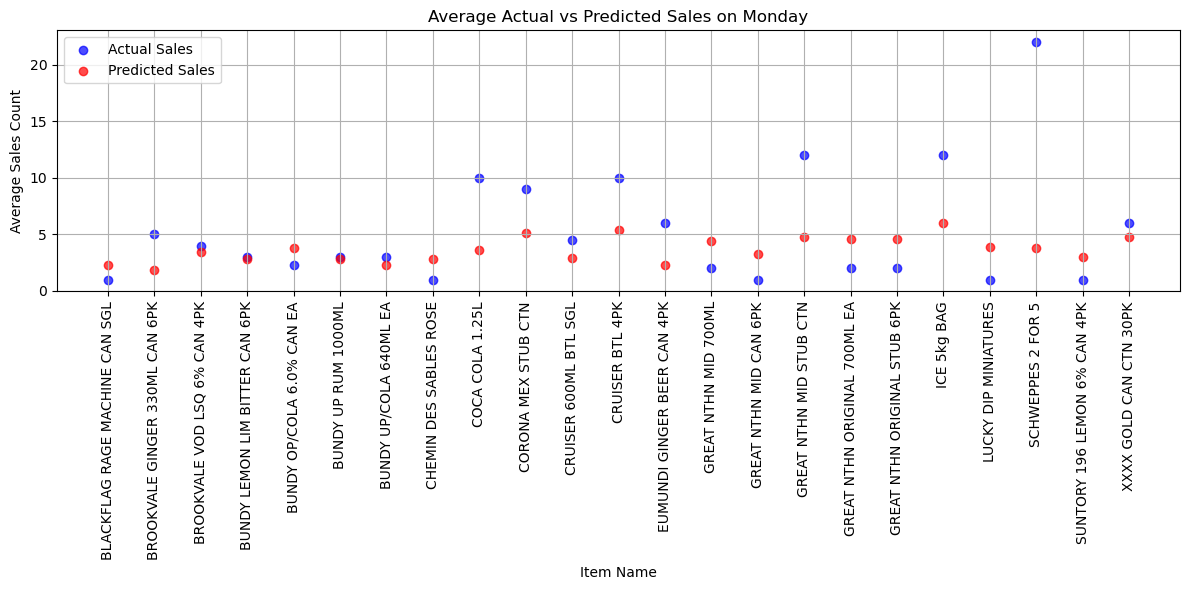

In [285]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred,
    'day_of_week': x_test['day_of_week']
})

grouped_df = result_df.groupby(['day_of_week', 'item_name']).agg(
    actual_sales=('actual_sales', 'mean'),
    predicted_sales=('predicted_sales', 'mean')
).reset_index()

monday_data = grouped_df[grouped_df['day_of_week'] == 5]

plt.figure(figsize=(12, 6))

plt.scatter(monday_data['item_name'], monday_data['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(monday_data['item_name'], monday_data['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Average Actual vs Predicted Sales on Monday')
plt.xlabel('Item Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)


plt.show()


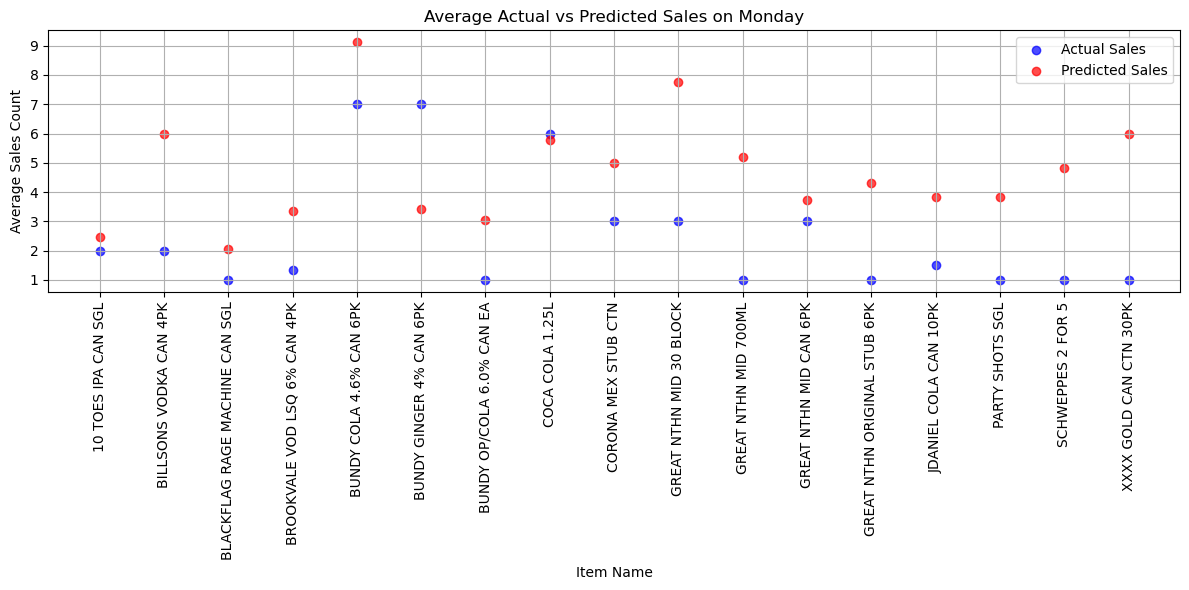

In [286]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.DataFrame({
    'item_name': x_test['item_name'],
    'actual_sales': y_test,
    'predicted_sales': y_pred,
    'day_of_week': x_test['day_of_week']
})

grouped_df = result_df.groupby(['day_of_week', 'item_name']).agg(
    actual_sales=('actual_sales', 'mean'),
    predicted_sales=('predicted_sales', 'mean')
).reset_index()

monday_data = grouped_df[grouped_df['day_of_week'] == 6]

plt.figure(figsize=(12, 6))

plt.scatter(monday_data['item_name'], monday_data['actual_sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.scatter(monday_data['item_name'], monday_data['predicted_sales'], label='Predicted Sales', color='red', alpha=0.7)

plt.title('Average Actual vs Predicted Sales on Monday')
plt.xlabel('Item Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True)


plt.show()


The item 'XXXX GOLD CAN 6PK' appears 6 times in the test set.
The item 'XXXX GOLD CAN 6PK' was sold a total of 230 times in the test set.


In [288]:
#Stuff for debugging
#XXXX GOLD CAN 6PK

In [289]:
print(x_test[x_test['item_name'] == 'XXXX GOLD CAN 6PK'])


      day_of_week          item_name  is_weekend  surrounding_sales  \
79              0  XXXX GOLD CAN 6PK           0                102   
587             3  XXXX GOLD CAN 6PK           0                 58   
827             1  XXXX GOLD CAN 6PK           0                 88   
951             3  XXXX GOLD CAN 6PK           0                147   
973             0  XXXX GOLD CAN 6PK           0                144   
1129            1  XXXX GOLD CAN 6PK           0                117   

      predicted_sales  
79          21.852140  
587         13.231270  
827         19.109136  
951         30.668939  
973         30.081152  
1129        24.791073  


In [290]:
item_name_to_search = 'XXXX GOLD CAN 6PK' 

all_entries_for_item = sales_df[sales_df['item_name'] == item_name_to_search]

print(f"All entries for the item '{item_name_to_search}':")
print(all_entries_for_item)

total_entries = len(all_entries_for_item)
total_sales_count = all_entries_for_item['sales_count'].sum()

print(f"\nThe item '{item_name_to_search}' appears {total_entries} times in the dataset.")
print(f"The item '{item_name_to_search}' was sold a total of {total_sales_count} times across all entries.")


All entries for the item 'XXXX GOLD CAN 6PK':
            date  day_of_week          item_name  sales_count  is_weekend  \
3     2022-12-01            3  XXXX GOLD CAN 6PK           52           0   
38    2022-12-11            6  XXXX GOLD CAN 6PK           20           1   
79    2022-12-19            0  XXXX GOLD CAN 6PK           19           0   
108   2022-12-10            5  XXXX GOLD CAN 6PK           16           1   
150   2022-12-27            1  XXXX GOLD CAN 6PK            6           0   
185   2022-12-02            4  XXXX GOLD CAN 6PK           33           0   
237   2022-12-24            5  XXXX GOLD CAN 6PK           16           1   
272   2022-12-03            5  XXXX GOLD CAN 6PK           15           1   
309   2022-12-18            6  XXXX GOLD CAN 6PK           25           1   
354   2022-12-08            3  XXXX GOLD CAN 6PK           50           0   
396   2022-12-09            4  XXXX GOLD CAN 6PK           52           0   
445   2022-12-26            0 

In [291]:
item_name_to_search = 'XXXX GOLD CAN 6PK'

all_entries_for_item = sales_df[sales_df['item_name'] == item_name_to_search]

print(f"All entries for the item '{item_name_to_search}':")
print(all_entries_for_item)


All entries for the item 'XXXX GOLD CAN 6PK':
            date  day_of_week          item_name  sales_count  is_weekend  \
3     2022-12-01            3  XXXX GOLD CAN 6PK           52           0   
38    2022-12-11            6  XXXX GOLD CAN 6PK           20           1   
79    2022-12-19            0  XXXX GOLD CAN 6PK           19           0   
108   2022-12-10            5  XXXX GOLD CAN 6PK           16           1   
150   2022-12-27            1  XXXX GOLD CAN 6PK            6           0   
185   2022-12-02            4  XXXX GOLD CAN 6PK           33           0   
237   2022-12-24            5  XXXX GOLD CAN 6PK           16           1   
272   2022-12-03            5  XXXX GOLD CAN 6PK           15           1   
309   2022-12-18            6  XXXX GOLD CAN 6PK           25           1   
354   2022-12-08            3  XXXX GOLD CAN 6PK           50           0   
396   2022-12-09            4  XXXX GOLD CAN 6PK           52           0   
445   2022-12-26            0 